In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir('/content/drive/MyDrive/CREDIT CARD FRAUD  DETECTION')

In [3]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn import metrics

from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.express as px

import seaborn as sns
import random

In [4]:
df_train_original = pd.read_csv('/content/drive/MyDrive/CREDIT CARD FRAUD  DETECTION/fraudTrain.csv')

df_train_original.drop(df_train_original.columns[0], axis=1, inplace=True)

df_test_original = pd.read_csv('/content/drive/MyDrive/CREDIT CARD FRAUD  DETECTION/fraudTest.csv')

df_test_original.drop(df_test_original.columns[0], axis=1, inplace=True)

# In order to seperate test and training subsets later on in the notebook
df_original = pd.concat([df_train_original,df_test_original], axis = 0)

In [5]:
# Define the proportion of the sample size we want
sample_size = 0.15

# Performing stratified sampling
df, _ = train_test_split(df_train_original, test_size=1-sample_size, stratify=df_train_original['is_fraud'], random_state=42)

# Displaying the sampled DataFrame
df.shape

(194501, 22)

EDA

In [6]:
def df_explore(df):
    missing = pd.DataFrame((df.isna().sum()/df.shape[0])*100).reset_index().rename(columns={'index': 'column',0:'%_missing'}).sort_values(by = '%_missing',ascending=False)
    nunique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index': 'column',0:'nunique'}).sort_values(by = 'nunique',ascending=False)
    dtypes = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index': 'column',0:'dtype'})
    return pd.merge(pd.merge(dtypes,missing,on='column'),nunique,on='column',how='left').sort_values(by='%_missing',ascending=False).sort_values(by = 'nunique', ascending = False)
print(df.shape)

df_explore(df).head(10)

(194501, 22)


,column,dtype,%_missing,nunique
17,trans_num,object,0.0,194501
20,merch_long,float64,0.0,194042
18,unix_time,int64,0.0,194009
0,trans_date_trans_time,object,0.0,194008
19,merch_lat,float64,0.0,193373
4,amt,float64,0.0,26167
1,cc_num,int64,0.0,968
8,street,object,0.0,968
11,zip,int64,0.0,957
13,long,float64,0.0,956


Text(0.5, 1.0, '% of Fraudulent vs Non-fraudulent transactions')

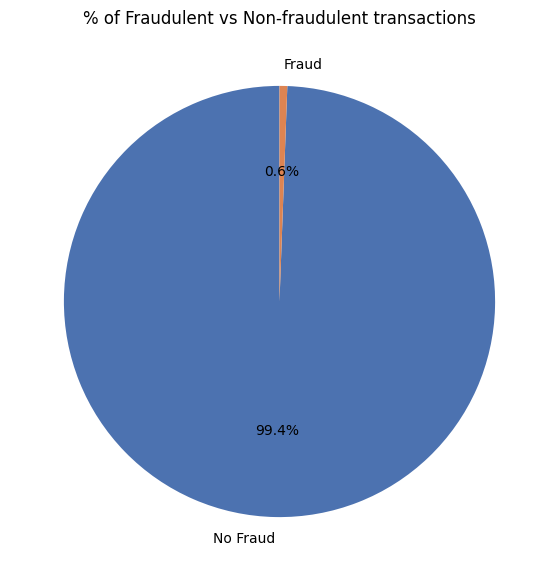

In [7]:
df['is_fraud_cat'] = df['is_fraud'].apply(lambda x: "Fraud" if x==1 else "No Fraud")

is_fraud_values = df['is_fraud_cat'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(is_fraud_values, labels=is_fraud_values.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("deep", n_colors=len(is_fraud_values)))
plt.title('% of Fraudulent vs Non-fraudulent transactions')

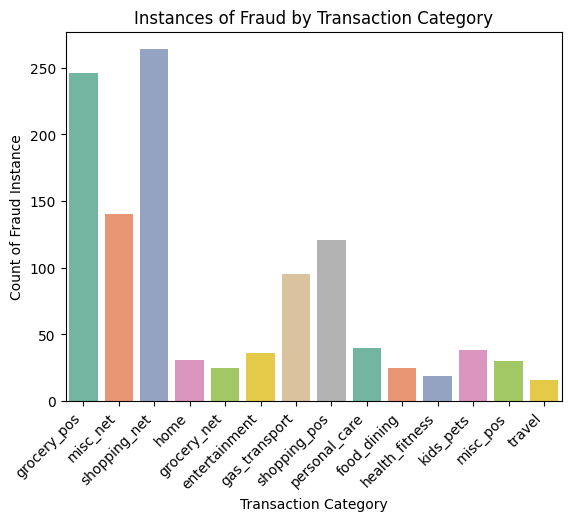

<Figure size 700x700 with 0 Axes>

In [8]:
sns.countplot(x="category", data=df[df['is_fraud_cat']=="Fraud"], palette="Set2", hue = 'category')

plt.title('Instances of Fraud by Transaction Category')
plt.xlabel('Transaction Category')
plt.ylabel('Count of Fraud Instance')
plt.xticks(rotation=45, ha = 'right')
plt.figure(figsize=(7, 7))
plt.show()

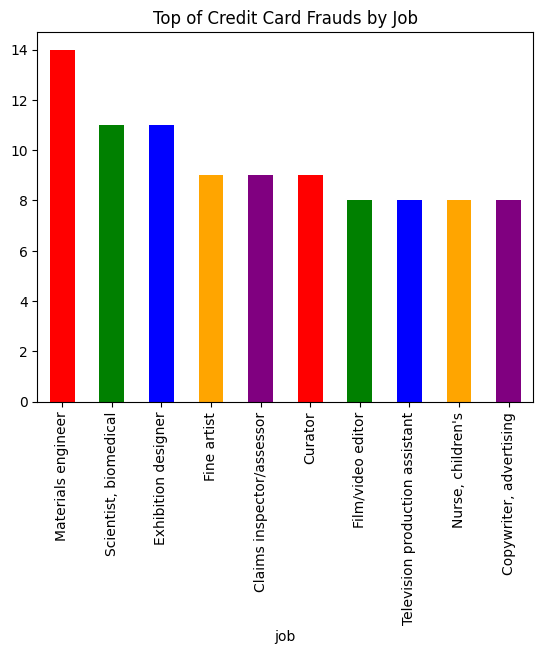

In [9]:
df[df['is_fraud_cat']=="Fraud"]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",x='job', y=df['is_fraud_cat']=="Fraud", color=['red', 'green', 'blue', 'orange', 'purple'])
plt.title("Top of Credit Card Frauds by Job")
plt.show()

Data Pre-processing

In [10]:
df2 = df.copy()

df2.drop_duplicates(inplace=True)

print("Duplicated values dropped")

Duplicated values dropped


In [11]:
def gender_transform(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
df2['gender'] = df2['gender'].transform(gender_transform)

In [12]:
df3 = df2.drop(['unix_time','trans_date_trans_time','cc_num','trans_num','street','dob','city','merchant','job','last','first','state','is_fraud_cat'],axis = 1)

In [13]:
df3_dummies = pd.get_dummies(df3.select_dtypes('object'), dtype = int)

df4 = pd.concat([df3.drop(df3.select_dtypes('object').columns, axis = 1), df3_dummies],axis = 1)

print(df4.shape)
df4.head()

(194501, 23)


,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
398918,55.05,0,37849,36.0435,-84.0400,25459,36.175640,-84.646341,0,0,...,0,0,0,1,0,0,0,0,0,0
655541,3.03,0,7208,40.6747,-74.2239,124967,40.939505,-74.256242,0,0,...,0,0,0,0,0,1,0,0,0,0
911788,139.01,1,45342,39.6321,-84.2675,36784,39.822635,-84.105583,0,1,...,0,0,0,0,0,0,0,0,0,0
86389,55.74,1,29032,34.3424,-80.5000,4424,34.962050,-80.168628,0,0,...,0,0,0,0,0,0,0,0,0,0
289156,93.78,1,73559,34.7032,-98.9591,540,34.068722,-98.940711,0,0,...,1,0,0,0,0,0,0,0,0,0


In [14]:
X = df4.reset_index(drop='index').drop('is_fraud', axis=1)

y = df4.reset_index(drop='index')['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [15]:
# Creating a function for scaling

def Standard_Scaler (df, col_names):

    features = df[col_names]

    scaler = StandardScaler().fit(features.values)

    features = scaler.transform(features.values)

    df[col_names] = features

    return df

col_names = ['amt']

X_train = Standard_Scaler (X_train, col_names)

X_test = Standard_Scaler (X_test, col_names)

Baseline Model (no imbalance resampling)

Random Forest

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

In [17]:
rf.fit(X_train, y_train)
y_pred_baseline = rf.predict(X_test)

In [18]:
print("Performance with imbalanced dataset:")
print(classification_report(y_test, y_pred_baseline))

Performance with imbalanced dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.87      0.56      0.68       338

    accuracy                           1.00     58351
   macro avg       0.93      0.78      0.84     58351
weighted avg       1.00      1.00      1.00     58351



In [19]:
cm = confusion_matrix(y_test, y_pred_baseline)

rf_baseline_Recall = recall_score(y_test, y_pred_baseline)
rf_baseline_Precision = precision_score(y_test, y_pred_baseline)
rf_baseline_f1 = f1_score(y_test, y_pred_baseline)
rf_baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

ndf = [(rf_baseline_Recall, rf_baseline_Precision, rf_baseline_f1, rf_baseline_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest performed with', 'Original (Imbalanced Dataset)')
rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.56213,0.86758,0.682226,0.996967


Random Resampling Methods for Imbalanced Data

In [20]:
from imblearn.over_sampling import RandomOverSampler
# defining oversampling method
ros = RandomOverSampler(random_state=42)

rf_oversample = RandomForestClassifier(n_estimators=200)
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [21]:
rf_oversample.fit(X_train_oversample, y_train_oversample)
y_pred_oversample = rf_oversample.predict(X_test)

In [22]:
print("Performance with Random Oversampling:")
print(classification_report(y_test, y_pred_oversample))


Performance with Random Oversampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.78      0.64      0.70       338

    accuracy                           1.00     58351
   macro avg       0.89      0.82      0.85     58351
weighted avg       1.00      1.00      1.00     58351



In [23]:
cm = confusion_matrix(y_test, y_pred_oversample)

oversample_rf_Recall = recall_score(y_test, y_pred_oversample)
oversample_rf_Precision = precision_score(y_test, y_pred_oversample)
oversample_rf_f1 = f1_score(y_test, y_pred_oversample)
oversample_rf_accuracy = accuracy_score(y_test, y_pred_oversample)

ndf_over = [(oversample_rf_Recall, oversample_rf_Precision, oversample_rf_f1, oversample_rf_accuracy)]

oversample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
oversample_rf_score.insert(0, 'Random Forest performed with', 'Random Oversampling')
oversample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.636095,0.784672,0.702614,0.996881


Random Undersampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler
# defining oversampling method
rus = RandomUnderSampler(random_state=42)

rf_undersample = RandomForestClassifier(n_estimators=200)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [25]:
rf_undersample.fit(X_train_undersample, y_train_undersample)
y_pred_undersample = rf_undersample.predict(X_test)

In [26]:
print("Performance with Random Undersampling:")
print(classification_report(y_test, y_pred_undersample))

Performance with Random Undersampling:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     58013
           1       0.11      0.93      0.19       338

    accuracy                           0.95     58351
   macro avg       0.55      0.94      0.58     58351
weighted avg       0.99      0.95      0.97     58351



In [27]:
cm = confusion_matrix(y_test, y_pred_undersample)

undersample_rf_Recall = recall_score(y_test, y_pred_undersample)
undersample_rf_Precision = precision_score(y_test, y_pred_undersample)
undersample_rf_f1 = f1_score(y_test, y_pred_undersample)
undersample_rf_accuracy = accuracy_score(y_test, y_pred_undersample)

ndf_over = [(undersample_rf_Recall, undersample_rf_Precision, undersample_rf_f1, undersample_rf_accuracy)]

undersample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
undersample_rf_score.insert(0, 'Random Forest performed with', 'Random Undersampling')
undersample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Undersampling,0.934911,0.105228,0.189165,0.953574


SMOTE (Synthetic Minority Oversampling Technique)

In [28]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [29]:
rf_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

In [30]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_smote))

Performance with SMOTE:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58013
           1       0.11      0.76      0.19       338

    accuracy                           0.96     58351
   macro avg       0.55      0.86      0.58     58351
weighted avg       0.99      0.96      0.98     58351



In [31]:
cm_smote = confusion_matrix(y_test, y_pred_smote)
rf_smote_Recall = recall_score(y_test, y_pred_smote)
rf_smote_Precision = precision_score(y_test, y_pred_smote)
rf_smote_f1 = f1_score(y_test, y_pred_smote)
rf_smote_accuracy = accuracy_score(y_test, y_pred_smote)

ndf = [(rf_smote_Recall, rf_smote_Precision, rf_smote_f1, rf_smote_accuracy)]

rf_smote_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_score.insert(0, 'Random Forest performed with', 'Smote Oversampling')
rf_smote_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Smote Oversampling,0.763314,0.108085,0.189358,0.962143


Tomek & SMOTE

In [32]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
SMOTETomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
rf_SMOTETomek = RandomForestClassifier(n_estimators=200)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.vali

In [33]:
rf_SMOTETomek.fit(X_train_SMOTETomek,y_train_SMOTETomek)
y_pred_SMOTETomek = rf_SMOTETomek.predict(X_test)

In [34]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_SMOTETomek))

Performance with SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.78      0.64      0.71       338

    accuracy                           1.00     58351
   macro avg       0.89      0.82      0.85     58351
weighted avg       1.00      1.00      1.00     58351



In [35]:
cm_smote_tomek = confusion_matrix(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Recall = recall_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Precision = precision_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_f1 = f1_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_accuracy = accuracy_score(y_test, y_pred_SMOTETomek)

ndf = [(rf_smote_tomek_Recall, rf_smote_tomek_Precision, rf_smote_tomek_f1, rf_smote_tomek_accuracy)]

rf_smote_tomek_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_tomek_score.insert(0, 'Random Forest performed with', 'SMOTE & Tomek')
rf_smote_tomek_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,SMOTE & Tomek,0.642012,0.783394,0.705691,0.996898


In [39]:
rf_sampling_scores = pd.concat([rf_score*100, oversample_rf_score*100, undersample_rf_score*100,rf_smote_score*100, rf_smote_tomek_score*100],axis = 0)
rf_sampling_scores

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset)Original (Imbalan...,56.213018,86.757991,68.222621,99.696663
0,Random OversamplingRandom OversamplingRandom O...,63.609467,78.467153,70.261438,99.688094
0,Random UndersamplingRandom UndersamplingRandom...,93.491124,10.522811,18.916492,95.357406
0,Smote OversamplingSmote OversamplingSmote Over...,76.331361,10.808546,18.935780,96.214289
0,SMOTE & TomekSMOTE & TomekSMOTE & TomekSMOTE &...,64.201183,78.339350,70.569106,99.689808


Applying best model

In [40]:
accuracy = accuracy_score(y_test, y_pred_undersample)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 95.36%


In [42]:
# remapping the classes
class_names = {1:'Fraud',0:'No Fraud'}
predicted_classes = [class_names[label] for label in y_pred_undersample]

# Mapping true labels to custom class names
class_map = [class_names[label] for label in y_test]

#Print the predicted and actual class names for the first 5 test samples
for i in range(30):
    print(f"Sample {i+1}: True Class: {class_map[i]}, Predicted Class: {predicted_classes[i]}")

Sample 1: True Class: No Fraud, Predicted Class: No Fraud
Sample 2: True Class: No Fraud, Predicted Class: No Fraud
Sample 3: True Class: No Fraud, Predicted Class: No Fraud
Sample 4: True Class: No Fraud, Predicted Class: No Fraud
Sample 5: True Class: No Fraud, Predicted Class: No Fraud
Sample 6: True Class: No Fraud, Predicted Class: No Fraud
Sample 7: True Class: No Fraud, Predicted Class: No Fraud
Sample 8: True Class: No Fraud, Predicted Class: No Fraud
Sample 9: True Class: No Fraud, Predicted Class: No Fraud
Sample 10: True Class: No Fraud, Predicted Class: No Fraud
Sample 11: True Class: No Fraud, Predicted Class: No Fraud
Sample 12: True Class: No Fraud, Predicted Class: No Fraud
Sample 13: True Class: No Fraud, Predicted Class: No Fraud
Sample 14: True Class: No Fraud, Predicted Class: No Fraud
Sample 15: True Class: No Fraud, Predicted Class: No Fraud
Sample 16: True Class: No Fraud, Predicted Class: No Fraud
Sample 17: True Class: No Fraud, Predicted Class: No Fraud
Sample